In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [4]:
import pickle  # Added import for pickle
import time

In [5]:
# Step 1: Load and Preprocess the Dataset
# Load the actual dataset
data = pd.read_csv('data/TR2EN.txt', sep='\t', names=['english', 'turkish'])

In [68]:
data = data[:350000]
data

,english,turkish
0,Hi.,Merhaba.
1,Hi.,Selam.
2,Run!,Kaç!
3,Run!,Koş!
4,Run.,Kaç!
...,...,...
349995,Tom didn't tell the police everything.,Tom polise her şeyi anlatmadı.
349996,Tom didn't tell the stranger his name.,Tom yabancıya adını söylemedi.
349997,Tom didn't tell us why we should come.,Tom bize niçin gelmemiz gerektiğini anlatmadı.
349998,Tom didn't think Mary was cooperative.,Tom Mary'nin yardımcı olduğunu düşünmedi.


In [69]:
# Step 2: Prepare input (English) and target (Turkish) texts
input_texts = data['english'].tolist()  # List of English sentences
# Add <start> and <end> tokens to target texts (modify preprocessing step)
target_texts = ['<start> ' + text + ' <end>' for text in data['turkish']]

### Set hyperparamaeter

In [6]:
output_dir = 'model_output/seq2seq'
latent_dim = 256
epochs = 20
batch_size = 64

In [71]:
# Tokenize the data# Step 3: Tokenize the input (English) texts
input_tokenizer = Tokenizer()
input_tokenizer.fit_on_texts(input_texts)
input_sequences = input_tokenizer.texts_to_sequences(input_texts)
input_maxlen = max(len(seq) for seq in input_sequences)
input_vocab_size = len(input_tokenizer.word_index) + 1

In [72]:
# Step 4: Tokenize the target (Turkish) texts
target_tokenizer = Tokenizer()
target_tokenizer.fit_on_texts(target_texts)
target_sequences = target_tokenizer.texts_to_sequences(target_texts)
target_maxlen = max(len(seq) for seq in target_sequences)
target_vocab_size = len(target_tokenizer.word_index) + 1

In [73]:
print(target_tokenizer.word_index['start'])  # Should print the index of <start>
print(target_tokenizer.word_index['end'])    # Should print the index of <end>

1
2


In [50]:
# Save tokenizers for later use
import pickle
with open(f'{output_dir}/tokenizer/input_tokenizer.pkl', 'wb') as f:
    pickle.dump(input_tokenizer, f)
with open(f'{output_dir}/tokenizer/target_tokenizer.pkl', 'wb') as f:
    pickle.dump(target_tokenizer, f)

In [51]:
# Save input_maxlen and target_maxlen
maxlen_dict = {'input_maxlen': input_maxlen, 'target_maxlen': target_maxlen}
with open(f'{output_dir}/tokenizer/maxlen_values.pkl', 'wb') as f:
    pickle.dump(maxlen_dict, f)
logger.info(f"Maxlen values saved: input_maxlen={input_maxlen}, target_maxlen={target_maxlen}")

NameError: name 'logger' is not defined

In [74]:
# Step 5: Pad sequences
input_sequences = pad_sequences(input_sequences, maxlen=input_maxlen, padding='post')
target_sequences = pad_sequences(target_sequences, maxlen=target_maxlen, padding='post')

In [75]:
# Step 6: Split data into training and validation sets (80% train, 20% validation)
train_input_seq, val_input_seq, train_target_seq, val_target_seq = train_test_split(
    input_sequences, target_sequences, test_size=0.2, random_state=42
)
train_input_texts, val_input_texts = train_test_split(input_texts, test_size=0.2, random_state=42)
train_target_texts, val_target_texts = train_test_split(target_texts, test_size=0.2, random_state=42)

In [76]:
# Prepare decoder input/output for training and validation
train_target_input_seq = train_target_seq[:, :-1]
train_target_output_seq = train_target_seq[:, 1:]

val_target_input_seq = val_target_seq[:, :-1]
val_target_output_seq = val_target_seq[:, 1:]

In [77]:
# Step 9: Define the Encoder
encoder_inputs = Input(shape=(input_maxlen,))
encoder_embedding = Embedding(input_vocab_size, latent_dim)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Step 10: Define the Decoder
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(target_vocab_size, latent_dim)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(target_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [78]:
# Step 11: Define and Compile the Model with Accuracy Metric
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['sparse_categorical_accuracy'])  # Add accuracy metric

In [79]:
# Step 12: Define Callbacks
modelcheckpoint = ModelCheckpoint(filepath=output_dir + "/weights.{epoch:02d}.hdf5", save_weights_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [80]:
# Step 13: Train the Model
history = model.fit(
    [train_input_seq, train_target_input_seq], train_target_output_seq,
    batch_size=batch_size, epochs=epochs,
    validation_data=([val_input_seq, val_target_input_seq], val_target_output_seq),
    callbacks=[modelcheckpoint, early_stopping],
    verbose=1
)

Epoch 1/20
   4/4375 [..............................] - ETA: 2:56:41 - loss: 11.1312 - sparse_categorical_accuracy: 0.5384  

KeyboardInterrupt: 

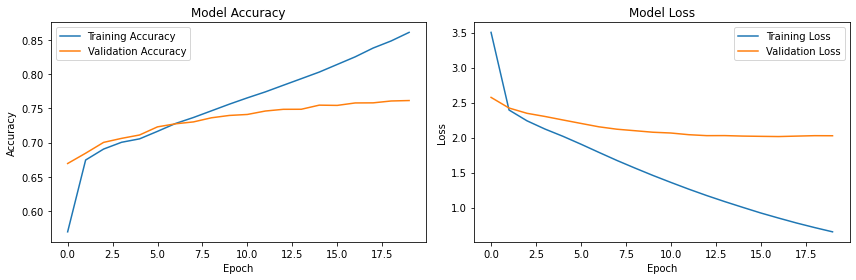

In [203]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
    
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
    
plt.tight_layout()
plt.show()
# plt.savefig(f'{OUTPUT_DIR}/plots/training_history.png')
plt.close()

In [204]:
# Step 14: Define Inference Models
encoder_model = Model(encoder_inputs, encoder_states, name='encoder_model')
decoder_state_input_h = Input(shape=(latent_dim,), name='decoder_state_input_h')
decoder_state_input_c = Input(shape=(latent_dim,), name='decoder_state_input_c')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states, name='decoder_model')

In [205]:
# Step 15: Save the Models
model.save(output_dir + '/training_model.h5')  # Save the full training model
encoder_model.save(output_dir + '/encoder_model.h5')  # Save the encoder model
decoder_model.save(output_dir + '/decoder_model.h5')  # Save the decoder model
print("Models saved successfully.")

Models saved successfully.


In [7]:
from tensorflow.keras.models import Model, load_model

In [8]:
# Step 16: Load Models and Translate
# Load tokenizers
with open(f'{output_dir}/tokenizer/input_tokenizer.pkl', 'rb') as f:
    loaded_input_tokenizer = pickle.load(f)
with open(f'{output_dir}/tokenizer/target_tokenizer.pkl', 'rb') as f:
    loaded_target_tokenizer = pickle.load(f)
    
with open(f'{output_dir}/tokenizer/maxlen_values.pkl', 'rb') as f:
    maxlen = pickle.load(f)

In [9]:
maxlen['target_maxlen']

19

In [10]:
# Load inference models
loaded_encoder_model = load_model(output_dir + '/encoder_model.h5', compile=False)
loaded_decoder_model = load_model(output_dir + '/decoder_model.h5', compile=False)


2025-03-20 12:02:14.286038: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /storage/icds/RISE/sw8/geos-3.11.2/lib64:/storage/icds/RISE/sw8/tiff-4.5.0/lib64:/storage/icds/RISE/sw8/gdal-3.6.4/lib64:/storage/icds/RISE/sw8/proj-9.2.0/lib64:/storage/icds/RISE/sw8/R-4.2.1-gcc-8.5.0/install/rpms/usr/lib64:/storage/icds/RISE/sw8/R-4.2.1-gcc-8.5.0/packages/usr/lib64:/storage/icds/RISE/sw8/R-4.2.1-gcc-8.5.0/install/packages/install/lib:/storage/icds/RISE/sw8/R-4.2.1-gcc-8.5.0/install/libs:/storage/icds/RISE/sw8/R-4.2.1-gcc-8.5.0/install/lib64/R/lib:/storage/icds/RISE/sw8/gsl-2.7.1/lib:/storage/icds/RISE/sw8/anaconda/anaconda3/envs/tensorflow/lib:/usr/lib64:/storage/icds/RISE/sw8/anaconda/anaconda3/lib
2025-03-20 12:02:14.286091: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2025-03-20 

In [11]:
# Define translation function using loaded models
def translate_sentence(sentence, encoder_model, decoder_model, input_tokenizer, target_tokenizer, input_maxlen, target_maxlen):
    # Preprocess input sentence
    input_seq = input_tokenizer.texts_to_sequences([sentence])
    input_seq = pad_sequences(input_seq, maxlen=input_maxlen, padding='post')
    
    # Encode the input
    states_value = encoder_model.predict(input_seq, verbose=0)
    
    # Decode step-by-step
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_tokenizer.word_index['<start>']
    stop_condition = False
    decoded_sentence = ''
    end_token_idx = target_tokenizer.word_index['<end>']
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = target_tokenizer.index_word.get(sampled_token_index, '')
        
        if sampled_word == '<end>' or len(decoded_sentence.split()) >= target_maxlen:
            stop_condition = True
        elif sampled_word != '<start>':
            decoded_sentence += sampled_word + ' '
        
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]
    
    return decoded_sentence.strip()

In [12]:
# Test translation with loaded models
test_sentence = "Hi."
translation = translate_sentence(test_sentence, loaded_encoder_model, loaded_decoder_model, 
                                loaded_input_tokenizer, loaded_target_tokenizer, maxlen['input_maxlen'],maxlen['target_maxlen'] )
print(f"Input Sentence: {test_sentence}")
print(f"Translated Sentence: {translation}")

Input Sentence: Hi.
Translated Sentence: Selam.


In [14]:
import torch
from transformers import MarianTokenizer, MarianMTModel


In [12]:




def load_and_translate(model_path, text, max_length=128, device=None):
    """
    Load a pre-trained MarianMT model and translate English text to Spanish.
    
    Args:
        model_path (str): Path to the directory containing the saved model and tokenizer
        text (str): English text to translate
        max_length (int): Maximum length of the input sequence (default: 128)
        device (str or torch.device): Device to run the model on (default: auto-detect)
    
    Returns:
        str: Translated Spanish text
    """
    try:
        # Set device if not specified
        if device is None:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Log the loading process
        print(f"Loading model from {model_path} for translation...")
        
        # Load tokenizer and model
        tokenizer = MarianTokenizer.from_pretrained(model_path)
        model = MarianMTModel.from_pretrained(model_path)
        
        # Move model to appropriate device
        model.to(device)
        model.eval()
        
        # Tokenize input text
        print(f"Tokenizing input text: '{text}'")
        inputs = tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding="max_length",
            max_length=max_length
        ).to(device)
        
        # Generate translation
        with torch.no_grad():
            translated = model.generate(**inputs)
        
        # Decode the translation
        translation = tokenizer.decode(translated[0], skip_special_tokens=True)
        print(f"Translated '{text}' to '{translation}'")
        
        return translation
    
    except Exception as e:
        print(f"Error during translation: {str(e)}")
        raise


In [13]:
# Example usage
if __name__ == "__main__":
    # Path to your saved model
    MODEL_PATH = '/storage/work/mqf5675/Masters/NLP/project/model_output/transformer_en_du'
    
    # Example translations
    try:
        # Single sentence
        result1 = load_and_translate(MODEL_PATH, "Hello, how are you?")
        print(f"Translation: {result1}")
        
        # Another example
        result2 = load_and_translate(MODEL_PATH, "go.")
        print(f"Translation: {result2}")
        
    except Exception as e:
        print(f"Failed to translate: {str(e)}")

Loading model from /storage/work/mqf5675/Masters/NLP/project/model_output/transformer_en_es for translation...
Tokenizing input text: 'Hello, how are you?'
Translated 'Hello, how are you?' to 'Hola, ¿cómo estás?'
Translation: Hola, ¿cómo estás?
Loading model from /storage/work/mqf5675/Masters/NLP/project/model_output/transformer_en_es for translation...
Tokenizing input text: 'go.'
Translated 'go.' to 've.'
Translation: ve.
